# Lecture 1 - Python Primer


> Learn just enough Python to start doing chemistry right away.

```{admonition} Who is this for?
Absolute beginners. If you can open a notebook and type, you can follow along.
```

```{contents}
:local:
:depth: 2
```

## Learning goals

- Run code cells in a notebook and switch between **Code** and **Markdown**.
- Use Python as a calculator for quick chemical math.
- Store values in **variables**, use **lists** and **dictionaries**.
- Write tiny **functions** to avoid repeating yourself.
- Make a simple **plot** for a chemistry relationship.
- Read error messages without panic.

::::{grid}
:gutter: 3

:::{grid-item-card} What you will do
^^^
- Compute molar masses
- Convert mass to moles
- Plot Beer-Lambert style data
+++
Keep this page open as a reference.
:::

:::{grid-item-card} What you will not do
^^^
- Heavy theory
- Long scripts
- Package installation rabbit holes
+++
We keep it short and friendly.
:::
::::

---

(content:setup)=
## 1. Setup - choose your path

`````{tab-set}
````{tab-item} Anaconda
Install **Anaconda** and open **JupyterLab**. Create a new notebook with the Python kernel.
````
````{tab-item} Miniconda
Install **Miniconda**, then in a terminal:
```bash
conda create -n aichem python=3.11 -y
conda activate aichem
pip install jupyter matplotlib numpy pandas
jupyter lab
```
Create a new notebook.
````
````{tab-item} Google Colab
Go to Colab, click **New Notebook**. When you see a code cell, you are ready.
````
`````

```{note}
If you already have a working notebook with {{ pyver }}, you are good to go.
```

---

(content:notebooks)=
## 2. Meet the notebook

- A notebook has **cells**.
- **Code cells** run Python.
- **Markdown cells** hold text, titles, and math like $PV = nRT$.

```{admonition} Handy keys
- `Shift+Enter` - run cell
- `A` - new cell above
- `B` - new cell below
- `M` - turn into Markdown
- `Y` - turn into Code
```

```{margin}
Tip - rename your notebook to `01_python_primer.ipynb`.
```

---

(content:calculator)=
## 3. Python as a calculator

Start with a code cell.

In [1]:
2 + 2

4

In [2]:
# Multiplication, division, powers
3 * 4, 10 / 4, 2 ** 5

(12, 2.5, 32)

```{admonition} Try it
Change the numbers and run again. Nothing breaks if you experiment.
```

### Common gotchas

````{warning}
- `10/3` gives a **float** like `3.3333333333`.
- `10//3` gives **integer division** `3`.
````

---

(content:variables)=
## 4. Variables - names for values

In [3]:
temperature_K = 298.15
R = 0.082057  # L·atm·mol^-1·K^-1
type(temperature_K), type(R)

(float, float)

```{note}
A variable is just a label that points to a value. You can reuse it many times.
```

---

(content:chem-quick)=
## 5. Quick chemistry - molar mass and moles

Let’s compute the molar mass of carbon dioxide.

In [4]:
C = 12.011
O = 15.999
M_CO2 = C + 2 * O
M_CO2

44.009

Convert mass to moles.

In [5]:
mass_g = 10.0
moles = mass_g / M_CO2
moles

0.22722624917630485

```{admonition} Exercise 5.1 - Water
Compute the molar mass of water and the moles in 36.0 g of water.
:class: dropdown

**Solution**
```python
H = 1.008
O = 15.999
M_H2O = 2*H + O
moles_water = 36.0 / M_H2O
M_H2O, moles_water
```
```

```{admonition} Exercise 5.2 - Mixture
You have 2.00 g of CO2 and 3.00 g of H2O. How many total moles of molecules are present?
:class: dropdown

**Hint** - compute each separately and add.
```

---

(content:lists-dicts)=
## 6. Tiny data structures - lists and dictionaries

A **list** holds an ordered collection.

In [6]:
acids = ["HCl", "HNO3", "H2SO4"]
acids[0], len(acids)

('HCl', 3)

A **dictionary** maps keys to values. Great for atomic weights.

In [7]:
aw = {"H": 1.008, "C": 12.011, "O": 15.999, "N": 14.007, "Cl": 35.45}
aw["O"], "H" in aw

(15.999, True)

```{admonition} Exercise 6.1
Build a dictionary for Na and Cl, then compute molar mass of NaCl.
:class: dropdown

**Solution**
```python
aw.update({"Na": 22.990, "Cl": 35.45})
M_NaCl = aw["Na"] + aw["Cl"]
M_NaCl
```
```

---

(content:functions)=
## 7. Functions - your own little tools

Write a function to compute molar mass from a simple formula string like `"CO2"` or `"H2O"`.

````{note}
We will accept only very simple formulas - element followed by optional one-digit count.
````

In [8]:
def molar_mass(formula, atomic_weights):
    total = 0.0
    i = 0
    while i < len(formula):
        # read element symbol
        if i+1 < len(formula) and formula[i+1].islower():
            elem = formula[i:i+2]
            i += 2
        else:
            elem = formula[i]
            i += 1
        # read optional count
        count = 0
        while i < len(formula) and formula[i].isdigit():
            count = count*10 + int(formula[i])
            i += 1
        count = count or 1
        total += atomic_weights[elem] * count
    return total

m_co2 = molar_mass("CO2", aw)
m_h2o = molar_mass("H2O", aw)
m_co2, m_h2o

(44.009, 18.015)

```{admonition} Try it
Test `"C6H12O6"`. Then compare with a hand calculation.
```

---

(content:control)=
## 8. Control flow - if and for

Classify solutions by a simple rule.

In [9]:
def classify_pH(pH):
    if pH < 7:
        return "acidic"
    elif pH > 7:
        return "basic"
    else:
        return "neutral"

[classify_pH(x) for x in [2.0, 7.0, 8.3]]

['acidic', 'neutral', 'basic']

Loop over formulas and report molar masses.

In [10]:
formulas = ["CO2", "H2O", "C6H12O6"]
for f in formulas:
    print(f, molar_mass(f, aw))

CO2 44.009
H2O 18.015
C6H12O6 180.156


---

(content:plot)=
## 9. First plot - a Beer-Lambert style line

Assume path length $b=1$ cm and molar absorptivity $\epsilon=120\ \mathrm{L\ mol^{-1}\ cm^{-1}}$. Plot absorbance vs concentration.

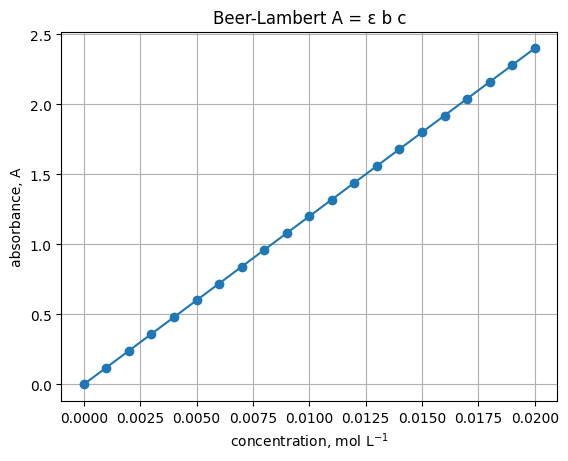

In [11]:
import numpy as np
import matplotlib.pyplot as plt

epsilon = 120.0   # L mol^-1 cm^-1
b = 1.0           # cm
c = np.linspace(0, 0.02, 21)     # mol L^-1
A = epsilon * b * c

plt.plot(c, A, marker="o")
plt.xlabel("concentration, mol L$^{-1}$")
plt.ylabel("absorbance, A")
plt.title("Beer-Lambert A = ε b c")
plt.grid(True)

```{admonition} Exercise 9.1
Change $\epsilon$ to 80 and re-run. What happens to the slope?
:class: dropdown

**Answer** - the line is less steep because absorbance is proportional to $\epsilon$.
```

---

(content:glue)=
## 10. Glue - reuse values in text

We can run a calculation and **paste** the result inside Markdown. This keeps your narrative and numbers in sync.

In [12]:
from myst_nb import glue
MW_ethanol = molar_mass("C2H6O", aw)
glue("MW_ethanol", MW_ethanol)

46.069

The molar mass of ethanol is **{glue:text}`MW_ethanol:.3f` g mol^-1**.

```{admonition} Why this helps
If you change the atomic weights or the formula later, the number in your text updates the next time you build the notebook or book.
```

---

(content:pv=nrt)=
## 11. Mini task - using $PV=nRT$

We will compute the pressure of 0.050 mol of gas at 298 K in a 2.0 L flask.

In [13]:
R = 0.082057  # L·atm·mol^-1·K^-1
n = 0.050
T = 298.0
V = 2.0
P_atm = n * R * T / V
P_atm

0.6113246500000001

```{admonition} Exercise 11.1
Change the temperature to 350 K. What is the new pressure in atm?
:class: dropdown

**Solution**
```python
T = 350.0
P_atm = n * R * T / V
P_atm
```
```

---

## 12. Reading errors without stress

Make a typo to see a helpful error.

```{code-cell} ipython3
# Remove the leading # and run to see a NameError
# print(molar_masss("CO2", aw))
```

```{admonition} Common message types
:class: tip
- **NameError** - you misspelled a name or used it before defining it.
- **TypeError** - you used the wrong kind of value.
- **KeyError** - dictionary key not found, e.g. `"Na"` missing from `aw`.
```

---

(content:challenges)=
## 13. Check your understanding

````{dropdown} Quiz - three quick checks
1. Which structure maps element symbols to masses?
   - A. list  
   - B. dictionary ✅  
   - C. string

2. If `A = ε b c`, doubling `b` while `ε` and `c` stay constant will:
   - A. halve absorbance  
   - B. double absorbance ✅  
   - C. do nothing

3. In `PV = nRT`, units must be consistent. If $R$ is in L atm mol^-1 K^-1 and $T$ is in K, what unit should $V$ use?
   - A. L ✅  
   - B. mL  
   - C. Pa
````
```{note}
mL also works if you convert to L before using the formula.
```

---

(content:glossary)=
## 14. Glossary

```{glossary}
variable
  A name that points to a value.
function
  A named block of code that returns a result.
dictionary
  A mapping from keys to values.
```

---

(content:references)=
## 15. Quick links

- [](content:setup) - setup options
- [](content:chem-quick) - chemistry math
- [](content:plot) - first plot

```{index} General Index
```

For a full index see [](genindex).

---

(content:extras)=
## 16. Optional extras

`````{admonition} Try a simple interactive widget
:class: dropdown
Colab and Jupyter can run widgets. If `ipywidgets` is available:
```python
# pip install ipywidgets   # if needed
import ipywidgets as w
import numpy as np
import matplotlib.pyplot as plt

def beer_lambert(epsilon=120.0):
    c = np.linspace(0, 0.02, 21)
    A = epsilon * 1.0 * c
    plt.figure()
    plt.plot(c, A, marker="o")
    plt.xlabel("concentration, mol L$^{-1}$")
    plt.ylabel("absorbance, A")
    plt.title(f"A = ε b c  (ε = {epsilon:.0f})")
    plt.grid(True)

w.interact(beer_lambert, epsilon=(20.0, 200.0, 10.0));
```
`````

---

## 17. What’s next

- Clean up your `molar_mass` function to support multi-digit counts like `"C12H22O11"`.  
- Read a small CSV of concentrations and plot absorbance.  
- Move on to the next lesson once you feel comfortable with variables, lists, dictionaries, functions, and plotting.

```{admonition} Save your work
Click **Save** or press `Ctrl+S`. Commit to version control if you use git.
```